<h1>
    Preprocessing in NLP
</h1>

<div id="top" ></div>

### Outline

- [Necessary Packages](#necessary_packages)
- [Global Parameters](#global_parameters)
- [Download the dataset](#download_the_dataset)
- [Load the dataset](#load_the_dataset)
- [Getting familiar with the data](#getting_familiar_with_the_data)
- [Text Cleaning](#text_cleaning)
  - [Handle repetitive characters](#handle_repetitive_characters)
  - [Managing homoglyphs](#managing_homoglyphs)
  - [Handle special entries](#handle_spetial_entries)
  - [Captilization](#captilization)
  - [Remove punctuation](#remove_punctuation)
  - [Removing stop words](#removing_stop_words)
- [Tokenization](#tokenization)
  - [Space based tokenization](#space_based_tokenization)
  - [Rule based tokenization](#rule_based_tokenization)
  - [Subword tokenization](#subword_tokenization)
- [Named Entity Recognition](#named_entity_recognition)
- [Stemming and lemmatization](#stemming_and_lemmatization)
- [Frequency Analysis](#frequency_analysis)

<div id="necessary_packages" >
    <h3>Necessary Packages</h3>
</div>

[Back to top](#top)

In [1]:
import pandas as pd
import numpy as np
import imageio
import requests
import string
import unicodedata
import email_normalize
import spacy
import os
import re
import nltk
import matplotlib.pyplot as plt
from textblob import TextBlob,Word
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize,sent_tokenize
from word_piece_tokenizer import WordPieceTokenizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from pywaffle import Waffle
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from w3lib.url import url_query_cleaner
from url_normalize import url_normalize
from bs4 import BeautifulSoup
from spacy.matcher import Matcher
import spacy.displacy as displacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.attrs import ORTH, NORM
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
tqdm.pandas()

In [4]:
nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -2]
[nltk_data]     Name or service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

- only run this if you don't have `en_core_web_lg` downloaded.

In [5]:
# !python -m spacy download en_core_web_lg

<div id="global_parameters" >
    <h3>Global Parameters</h3>
</div>

[Back to top](#top)

In [6]:
DOWNLOAD_DATASET = False
DATASET_URL = "https://raw.githubusercontent.com/GU4243-ADS/spring2018-project1-ginnyqg/master/data/spooky.csv"
DATA_DIR = os.path.join(".","data")
DATASET_PATH = os.path.join(DATA_DIR, "spooky.csv")

<div id="download_the_dataset" >
    <h3>Download the dataset</h3>
</div>

[Back to top](#top)

In [7]:
if DOWNLOAD_DATASET:
    response = requests.get(DATASET_URL)
    content = response.text
    if not os.path.isdir(DATA_DIR):
        os.mkdir(DATA_DIR)
    with open(DATASET_PATH, "w") as f:
        f.write(content)
else:
    print("Dataset download is deactivated")

Dataset download is deactivated


<div id="load_the_dataset" >
    <h3>Load the dataset</h3>
</div>

[Back to top](#top)

In [8]:
df = pd.read_csv(DATASET_PATH)

<div id="getting_familiar_with_the_data" >
    <h3>Getting familiar with the data</h3>
</div>

[Back to top](#top)

- Show the columns of the dataframe

In [9]:
df.columns

Index(['id', 'text', 'author'], dtype='object')

- Check the dimensions of the dataframe

In [10]:
df.shape

(19579, 3)

- display the first 10 samples

In [11]:
df.head(n=10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


- check for missing values

In [12]:
df.isna().sum()

id        0
text      0
author    0
dtype: int64

- check for duplicates

In [13]:
df.duplicated().sum()

0

<div id="text_cleaning" >
    <h3>Text Cleaning</h3>
</div>

[Back to top](#top)

<div id="handle_repetitive_characters" >
    <h4>Handle repetitive characters</h4>
</div>

[Back to top](#top)

In [14]:
def remove_repititive_chars(word,rx=re.compile(r'([^\W\d_])\1{2,}')):
    return re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), word)

In [15]:
remove_repititive_chars("cooool i'm haaaapy")

"cool i'm happy"

In [16]:
df["text"] = df["text"].progress_apply(remove_repititive_chars)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="managing_homoglyphs" >
    <h4>Managing homoglyphs</h4>
</div>

[Back to top](#top)

To insure handling homoglyphes we will perform several operations

- Correcting words using textblob as shown in the examples bellow it managed to correct the words `$tupid`,`h1ll` and `c@mp`,we won't perform this transformation again since we've already applied it above.

- Unicode characters normalization, to determine whether any two Unicode strings are equivalent to each other, for example `ℌ` and `H`, it also removes accents.

In [17]:
print(Word("$tupid").correct())
print(Word("h1ll").correct())
print(Word("c@mp").correct())

stupid
hill
camp


In [18]:
def normalaize_unicode_chars(text):
  text = unidecode(text)
  return text

In [19]:
normalaize_unicode_chars('ℌℌℌ kožušček')

'HHH kozuscek'

In [20]:
df["text"] = df["text"].progress_apply(normalaize_unicode_chars)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="handle_spetial_entries" >
    <h4>Handle special entries</h4>
</div>

[Back to top](#top)

- Urls can come on different forms (different protocol for example `http` and `https`,with different query parameters with or without an extra `/` at the end) all these differences should be eleminated to not confuse the model.

In [21]:
def canonical_url(u):
    u = url_normalize(u)
    u = u.split('?')[0]

    if u.startswith("http://"):
        u = u[7:]
    if u.startswith("https://"):
        u = u[8:]
    if u.startswith("www."):
        u = u[4:]
    if u.endswith("/"):
        u = u[:-1]
    return u

In [22]:
urls = [
  'example.com',
  'example.com/',
  'https://example.com/',
  'http://example.com',
  'http://example.com?',
  'http://example.com/?',
  'http://example.com//',
  'http://example.com?utm_source=Google'
]

In [23]:
list(map(canonical_url, urls))

['example.com',
 'example.com',
 'example.com',
 'example.com',
 'example.com',
 'example.com',
 'example.com',
 'example.com']

- Emails can also come under different formats,email normalization is the process of tidying up an email into a consistent format which can still be used to contact the user,This will convert the email to lowercase, remove dots (. ), and plus signs followed by arbitrary strings (+foobar).

In [24]:
def normalize_email(email_address: str):
    result = email_normalize.normalize(email_address)
    return result.normalized_address

In [82]:
normalize_email('f.o.o+bar@gmail.com')

'foo@gmail.com'

- For the html tags we will remove them since we only care about the content they hold.

In [26]:
def remove_html_tags(text):
    return re.sub(" +"," ",BeautifulSoup(text, 'html.parser').get_text().replace("\n"," ")).strip()

In [27]:
remove_html_tags("""
<!DOCTYPE html>
<html>
  <body>

  <h1>My First JavaScript</h1>

  <button type="button"
    onclick="document.getElementById('demo').innerHTML = Date()">
    Click me to display Date and Time.
  </button>

  <p id="demo"></p>

  </body>
</html>
""")

'My First JavaScript Click me to display Date and Time.'

In [28]:
url_regex = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
def handle_special_entries(text):
  text = re.sub(url_regex, lambda x : canonical_url(x.group()), text)
  text = re.sub(email_regex, lambda x : normalize_email(x.group()), text)
  text = remove_html_tags(text)
  return text

- a full example

In [29]:
text = "Hello http://www.youtube.com f.o.o+bar@gmail.com <b>Hello</b>"
handle_special_entries(text)

'Hello youtube.com f.o.o+bar@gmail.com Hello'

In [30]:
df["text"] = df["text"].progress_apply(handle_special_entries)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="captilization" >
    <h4>Captilization</h4>
</div>

[Back to top](#top)

In [31]:
df["text"] = df["text"].progress_apply(str.lower)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="remove_punctuation" >
    <h4>Remove punctuation</h4>
</div>

[Back to top](#top)

In [32]:
spetial_chars = string.punctuation
escaped_chars = [re.escape(c) for c in spetial_chars]
spetial_chars_regex = re.compile(f"({'|'.join(escaped_chars)})")

In [33]:
def remove_punctuation(text):
  return re.sub(spetial_chars_regex," ",text)

In [34]:
remove_punctuation("Hello,World !")

'Hello World  '

In [35]:
df["text"] = df["text"].progress_apply(remove_punctuation)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="removing_stop_words" >
    <h4>Removing stop words</h4>
</div>

[Back to top](#top)

In [36]:
eng_stopwords = set(stopwords.words("english"))

In [37]:
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in eng_stopwords]
    return ' '.join(tokens)

In [38]:
df["text"] = df["text"].progress_apply(remove_stopwords)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="tokenization" >
    <h3>Tokenization</h3>
</div>

[Back to top](#top)

<div id="space_based_tokenization" >
    <h4>space based tokenization</h4>
</div>

[Back to top](#top)

In [39]:
space_based_vocab = []

In [40]:
_ = df["text"].progress_apply(lambda x : space_based_vocab.extend(word_tokenize(x)))

  0%|          | 0/19579 [00:00<?, ?it/s]

In [41]:
space_based_vocab = set(space_based_vocab)

In [42]:
len(space_based_vocab)

24911

<div id="rule_based_tokenization" >
    <h4>Rule based tokenization</h4>
</div>

- Rule 1 : `Hello World` -> [`Hello`, `World`]
- Rule 2 : `can't` -> [`can`,`not`]
- Rule 3 : `won't` -> [`will`,`not`]
- Rule 4 : `gimme` -> [`give`, `me`]
- Rule 5 : `don't` -> [`do`, `not`]

In [43]:
def make_tokenizer():

    rules = {
        "can't":[{ORTH: "ca",NORM:"can"}, {ORTH: "n't", NORM:"not"}],
        "don't":[{ORTH: "do"}, {ORTH: "n't", NORM:"not"}],
        "won't":[{ORTH: "wo",NORM:"will"}, {ORTH: "n't", NORM:"not"}],
        "gimme":[{ORTH: "gim",NORM:"give"}, {ORTH: "me"}],
    }


    nlp = English()
    tokenizer = Tokenizer(nlp.vocab,rules=rules)

    return tokenizer

In [44]:
tokenizer = make_tokenizer()
text = "don't can't won't gimme hello world"
print([t.norm_ for t in tokenizer(text)])

['do', 'not', 'can', 'not', 'will', 'not', 'give', 'me', 'hello', 'world']


In [45]:
rule_based_vocab = []

In [46]:
_ = df["text"].progress_apply(lambda x : rule_based_vocab.extend([t.norm_ for t in tokenizer(x)]))

  0%|          | 0/19579 [00:00<?, ?it/s]

In [47]:
rule_based_vocab = set(rule_based_vocab)

In [48]:
len(rule_based_vocab)

24911

<div id="subword_tokenization" >
    <h4>Subword tokenization</h4>
</div>

In [49]:
tokenizer = WordPieceTokenizer()

In [50]:
def wordpiece(text):
    ids = tokenizer.tokenize(text)
    return tokenizer.convert_ids_to_tokens(ids)

In [51]:
subword_vocab = []

In [52]:
_ = df["text"].progress_apply(lambda x : subword_vocab.extend(wordpiece(x)))

  0%|          | 0/19579 [00:00<?, ?it/s]

In [53]:
subword_vocab = set(subword_vocab)

In [54]:
len(subword_vocab)

15824

<div id="named_entity_recognition" >
    <h3>Named Entity Recognition</h3>
</div>

[Back to top](#top)

In [55]:
nlp = spacy.load("en_core_web_lg")

In [56]:
doc = nlp(df["text"].iloc[50])
print(f'The text : {df["text"].iloc[50]}')
print(f'\nNamed Entities :\n')
for i,ent in enumerate(doc.ents):
    print(f"NER {i} = (text={ent.text}, start_char={ent.start_char}, end_char={ent.end_char}, label={ent.label_})")

The text : ellison remarkable continuous profusion good gifts lavished upon fortune

Named Entities :

NER 0 = (text=ellison, start_char=0, end_char=7, label=PERSON)


<div id="stemming_and_lemmatization" >
    <h3>Stemming and lemmatization</h3>
</div>

[Back to top](#top)

- Stemming

In [57]:
stemmer = SnowballStemmer(language="english")

In [58]:
def stem(text):
  tokens = word_tokenize(text)
  token = [stemmer.stem(token) for token in tokens]
  return ' '.join(token)

In [59]:
stemmer.stem("introduction generalization")

'introduction gener'

In [60]:
df["stemmed_text"] = df["text"].progress_apply(stem)

  0%|          | 0/19579 [00:00<?, ?it/s]

- Lemmatization

In [61]:
lemmatizer = WordNetLemmatizer()

In [62]:
def lemmatize(text):
  tokens = word_tokenize(text)
  token = [lemmatizer.lemmatize(token) for token in tokens]
  return ' '.join(token)

In [63]:
df["lemmatized_text"] = df["text"].progress_apply(lemmatize)

  0%|          | 0/19579 [00:00<?, ?it/s]

<div id="frequency_analysis" >
    <h3>Frequency analysis</h3>
</div>

[Back to top](#top)

In [64]:
grouped_df = df[["text","author"]].groupby(by="author").agg(' '.join)

In [65]:
cv = CountVectorizer().fit(grouped_df["text"])
counts = cv.transform(grouped_df["text"])
counts_df = pd.DataFrame(data=counts.toarray(),index=grouped_df.index,columns=cv.get_feature_names_out())

- For the word great

In [66]:
counts_df["great"]

author
EAP    227
HPL    195
MWS     90
Name: great, dtype: int64

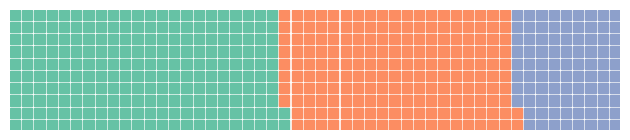

In [67]:
_ = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=50,
    values=counts_df['great'],
)

- impossible

In [68]:
counts_df["impossible"]

author
EAP    64
HPL    16
MWS    19
Name: impossible, dtype: int64

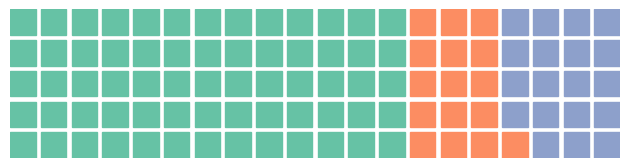

In [69]:
_ = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=20,
    values=counts_df['impossible'],
)

- Word Clouds

In [70]:
def show_wordclouds(grouped_df, author):
    wc1 = WordCloud().generate(grouped_df["text"].loc[author])
    plt.imshow(wc1)

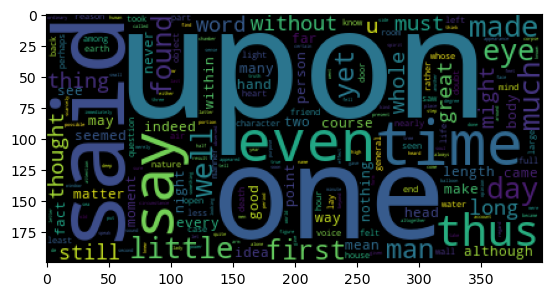

In [71]:
show_wordclouds(grouped_df, "EAP")

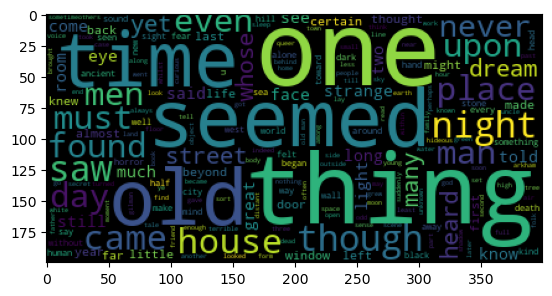

In [72]:
show_wordclouds(grouped_df, "HPL")

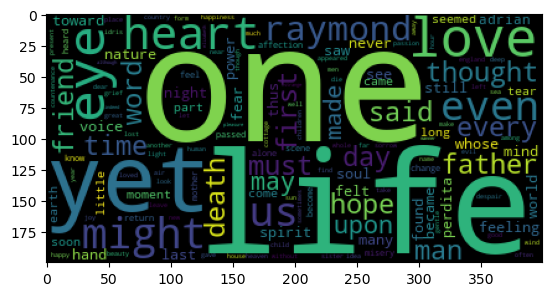

In [73]:
show_wordclouds(grouped_df, "MWS")

- Display Negative and positive words

In [75]:
class WordSentitmentAnalyser:

    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()

    def classify_word(self, word):
        return self.sia.polarity_scores(word)["compound"]

    def analyse_words(self, words):
        sentiment_scores = np.array(list(map(self.classify_word, words)))
        return sentiment_scores

    def plot_topk_words(self,words,mask=None,word_cloud_config={},pos_config={},neg_config={},k=100):
        sentiment_scores = self.analyse_words(words)
        sentiment_scores_idx = sentiment_scores.argsort()
        top_k_positive_words = words[sentiment_scores_idx[-k:]]
        top_k_negative_words = words[sentiment_scores_idx[:k]]

        positive_word_cloud = WordCloud(**{**word_cloud_config,**pos_config})
        negative_word_cloud = WordCloud(**{**word_cloud_config,**neg_config})

        positive_word_cloud.generate_from_text(' '.join(top_k_positive_words))
        negative_word_cloud.generate_from_text(' '.join(top_k_negative_words))

        positive_word_cloud.recolor(colormap='Greens')
        negative_word_cloud.recolor(colormap='Reds')

        word_cloud = np.vstack([positive_word_cloud.to_array(),negative_word_cloud.to_array()])

        plt.imshow(word_cloud)

In [76]:
analyzer = WordSentitmentAnalyser()

In [77]:
mask = plt.imread('black-pear.jpg')
pos_mask = mask[:1500]
neg_mask = mask[1500:]

In [78]:
eap_words = counts_df.columns[counts_df.loc["EAP"] != 0]

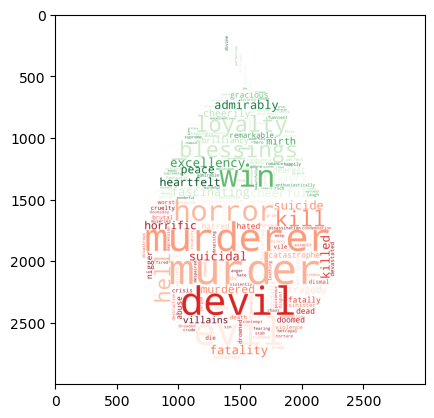

In [79]:
analyzer.plot_topk_words(eap_words,
    word_cloud_config={"background_color":"white"},
    pos_config={"mask":pos_mask},
    neg_config={"mask":neg_mask}
)

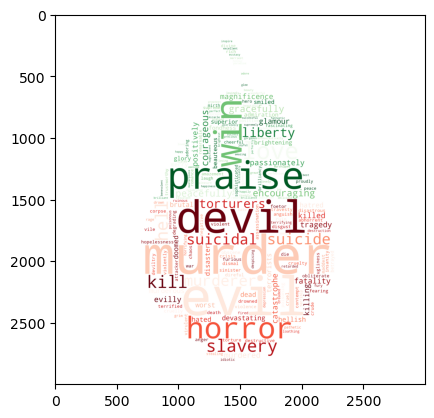

In [80]:
hpl_words = counts_df.columns[counts_df.loc["HPL"] != 0]
analyzer.plot_topk_words(hpl_words,
    word_cloud_config={"background_color":"white"},
    pos_config={"mask":pos_mask},
    neg_config={"mask":neg_mask}
)

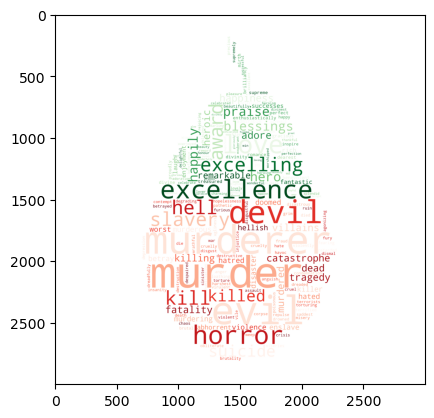

In [81]:
mws_words = counts_df.columns[counts_df.loc["MWS"] != 0]
analyzer.plot_topk_words(mws_words,
    word_cloud_config={"background_color":"white"},
    pos_config={"mask":pos_mask},
    neg_config={"mask":neg_mask}
)

[Back to top](#top)